# Project description

**Determining the age of customers**

The "Bread and Salt" network supermarket is implementing a computer vision system to process photos of customers. Photographing in the checkout area will help determine the age of customers in order to:

- Analyze purchases and offer products that may interest customers of that age group;
- Monitor the honesty of cashiers when selling alcohol.

Build a model that will determine the approximate age of a person based on a photo. You have a set of photos of people with their age specified at your disposal.

# Table of contents

---

1. [Data](#data)
    * [Age distribution](#data-age-distribution)
    * [Pictures](#data-pictures)
    * [Conclusion](#data-conclusion)
2. [Training the model](#training-the-model)
3. [Analysis of the trained model](#analysis-of-the-trained-model)
---

## Data <a class="anchor" id="data"></a>

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Searching for file
file_names = ['labels.csv']
url = '/datasets/faces/labels.csv'

file_path = None

for root, dirs, files in os.walk('.'):
    for file_name in file_names:
        if file_name in files:
            file_path = os.path.join(root, file_name)
            break
    else:
        continue
    break

if file_path is not None:
    labels = pd.read_csv(file_path)
else:
    labels = pd.read_csv(url)

# Ignoring all warnings and displaying all columns in the DF
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Basic information
print(f"Shape of dataframe: {labels.shape}")
print(f"-" * 26)
print(f"Dataframe info: \n")
print(labels.info())
print(f"-" * 26)
display(labels.describe())
labels.sample(5)

Shape of dataframe: (7591, 3)
--------------------------
Dataframe info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7591 non-null   int64 
 1   file_name   7591 non-null   object
 2   real_age    7591 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.0+ KB
None
--------------------------


,Unnamed: 0,real_age
count,7591.00000,7591.000000
mean,3795.00000,31.201159
std,2191.47728,17.145060
min,0.00000,1.000000
25%,1897.50000,20.000000
50%,3795.00000,29.000000
75%,5692.50000,41.000000
max,7590.00000,100.000000


,Unnamed: 0,file_name,real_age
6937,6937,006948.jpg,38
1435,1435,001435.jpg,2
6244,6244,006248.jpg,16
293,293,000293.jpg,45
4193,4193,004193.jpg,18


In [3]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


### Age distribution <a class="anchor" id="data-age-distribution"></a>

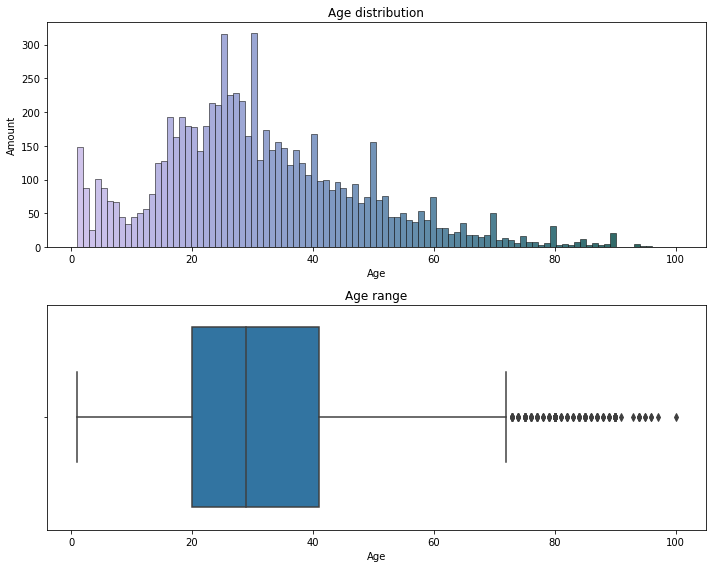

In [4]:
# Custom color palette and size
cm = sns.color_palette('ch:s=1.9, r=.5, d=.3, l=0.8', 100)

fig, axs = plt.subplots(nrows=2, figsize=(10, 8))

# Histogram
sns.histplot(ax=axs[0], x='real_age', data=labels, bins=100)
for bin_, i in zip(axs[0].patches, cm):
    bin_.set_facecolor(i)
    
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Amount')
axs[0].set_title('Age distribution')

# Boxplot
sns.boxplot(ax=axs[1], x='real_age', data=labels)
axs[1].set_xlabel('Age')
axs[1].set_title('Age range')

plt.tight_layout()
plt.show()

### Pictures <a class="anchor" id="data-pictures"></a>

Showing 15 random pictures:

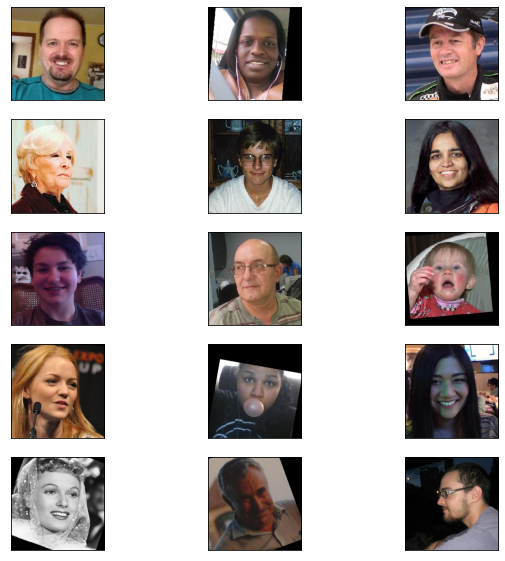

In [5]:
features, target = next(train_gen_flow)

plt.figure(figsize=(10, 10))

for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.grid(False)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])

### Conclusion <a class="anchor" id="data-conclusion"></a>

The initial data review revealed that the dataset contains two columns:
- file name;
- age of the person in the image. The sample size is 7591 images.

After conducting exploratory data analysis and examining the age distribution, we can summarize (by comparing the data with the output of the `describe()` method):
- the average age of a person in the dataset is 30 years old;
- the histogram of the distribution shows elevated values in the range of 20 to 40 years old, 0 to 10 years old, and peak values at 50, 60, 70, 80, and 90 years old.

The selected photos have different characteristics, such as:
- some photos are presented in black and white;
- some photos have an internal fold and varying sizes;
- not all photos have the person looking directly into the camera.

## Training the model <a class="anchor" id="training-the-model"></a>

The code in the cell below was executed in a separate Jupyter Notebook project using a different runtime (GPU hardware accelerator), so it is presented here as text.

```python

import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25, horizontal_flip=True, rescale=1.0 / 255
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + '/labels.csv'),
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345,
    )
    return train_datagen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(
        validation_split=0.25, rescale=1.0 / 255
        )
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + '/labels.csv'),
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345,
    )
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
        )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=15, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(
        loss='mean_squared_error', optimizer=optimizer, metrics=['mae']
        )

    return model


def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=15,
    steps_per_epoch=None,
    validation_steps=None,
):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
    )

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/15
2022-09-23 20:53:03.602257: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-23 20:53:04.043468: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 52s - loss: 291.0371 - mae: 12.1268 - val_loss: 733.7436 - val_mae: 22.1287
Epoch 2/15
178/178 - 48s - loss: 77.6440 - mae: 6.6284 - val_loss: 538.2211 - val_mae: 17.9463
Epoch 3/15
178/178 - 48s - loss: 51.1287 - mae: 5.4282 - val_loss: 221.0739 - val_mae: 11.8603
Epoch 4/15
178/178 - 48s - loss: 37.6745 - mae: 4.7039 - val_loss: 235.8445 - val_mae: 11.9067
Epoch 5/15
178/178 - 38s - loss: 27.7255 - mae: 3.9805 - val_loss: 84.0169 - val_mae: 6.8218
Epoch 6/15
178/178 - 38s - loss: 21.5215 - mae: 3.5276 - val_loss: 68.9143 - val_mae: 6.1969
Epoch 7/15
178/178 - 38s - loss: 17.1439 - mae: 3.1396 - val_loss: 75.6915 - val_mae: 6.3674
Epoch 8/15
178/178 - 37s - loss: 13.4756 - mae: 2.7842 - val_loss: 78.8060 - val_mae: 6.5077
Epoch 9/15
178/178 - 37s - loss: 12.1464 - mae: 2.6071 - val_loss: 70.0283 - val_mae: 6.1506
Epoch 10/15
178/178 - 38s - loss: 9.5988 - mae: 2.3371 - val_loss: 79.0125 - val_mae: 6.5263
Epoch 11/15
178/178 - 38s - loss: 8.9637 - mae: 2.2388 - val_loss: 62.9137 - val_mae: 5.8272
Epoch 12/15
178/178 - 38s - loss: 7.9506 - mae: 2.1503 - val_loss: 88.2725 - val_mae: 7.4039
Epoch 13/15
178/178 - 38s - loss: 7.2034 - mae: 2.0337 - val_loss: 61.7692 - val_mae: 5.8679
Epoch 14/15
178/178 - 38s - loss: 6.9852 - mae: 2.0200 - val_loss: 66.2790 - val_mae: 5.9625
Epoch 15/15
178/178 - 37s - loss: 6.2616 - mae: 1.8883 - val_loss: 62.5486 - val_mae: 5.8394
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 62.5486 - mae: 5.8394
Test MAE: 5.8394


```

## Analysis of the trained model <a class="anchor" id="analysis-of-the-trained-model"></a>

The trained model, built on the `ResNet50` architecture, achieved a MAE result of `5.8394`. The dataset used for training was 25% of the original 7951. The dataset contains images of different quality, color saturation, and internal image rotation. Four layers were added to the multi-layer model:

1. Backbone: a `ResNet` network pre-trained on `imagenet`
2. GlobalAveragePooling2D
3. Dense with 15 neurons
4. Dense with 1 neuron

The following parameters were used for training the model:

1. Learning rate for the `Adam` optimizer: 0.0001
2. Number of passes of the dataset through the network (epochs): 15
3. Batch size: 32

During the training process, overfitting was not observed.